{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

* Calculate `dNBR` in **Python**.

</div>


As discussed in the previous lesson, you can use dNBR to map the extent and
severity of a fire. In this lesson, you learn how to create NBR using
Landsat data.

You calculate dNBR using the following steps:

1. Open up pre-fire data and calculate *NBR*
2. Open up the post-fire data and calculate *NBR*
3. Calculate **dNBR** (difference NBR) by subtracting post-fire NBR from pre-fire NBR (NBR pre - NBR post fire).
4. Classify the dNBR raster using the classification table.


## Calculate dNBR Using Landsat Data

First, import your Python libraries.


In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import seaborn as sns
import numpy as np
from shapely.geometry import mapping, box
from rasterio.plot import plotting_extent
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

# Download data and set working directory
data1 = et.data.get_data('cold-springs-fire')
data2 = et.data.get_data('cs-test-landsat')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

To calculate difference Normalized Burn Ratio (dNBR), you first need to calculate NBR for the pre and post fire data. This, of course, presumes that you have data before and after the area was burned from the same remote sensing sensor. Ideally, this data also does not have clouds covering the fire area.

Open up and stack the Landsat post-fire data. You will use the same function that 
we introduced in the <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/open-and-crop-data/">first Landsat lesson.</a>

In [2]:
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"] = i+1

    return xr.concat(out_xr, dim="band")

In [3]:
# Import and stack post fire Landsat data - notice you are only stacking bands 5-7
all_landsat_bands_path = glob(os.path.join("cold-springs-fire",
                                           "landsat_collect",
                                           "LC080340322016072301T1-SC20180214145802",
                                           "crop",
                                           "*band[5-7]*.tif"))

all_landsat_bands_path.sort()

landsat_post_fire = combine_tifs(all_landsat_bands_path)
landsat_post_fire

<xarray.DataArray (band: 3, y: 177, x: 246)>
array([[[2445., 2271., 2417., ..., 1734., 1904., 2101.],
        [2662., 2465., 2532., ..., 1736., 1824., 2165.],
        [2880., 2872., 2750., ..., 1897., 2116., 2300.],
        ...,
        [1900., 1917., 2076., ..., 1722., 1891., 1890.],
        [1779., 1893., 1983., ..., 1645., 1847., 2090.],
        [1553., 1440., 1587., ..., 1562., 1689., 1964.]],

       [[2864., 2974., 3108., ...,  983., 1195., 1271.],
        [2527., 2827., 3008., ..., 1132., 1293., 1546.],
        [2141., 2427., 2433., ..., 1324., 1652., 1922.],
        ...,
        [1662., 1757., 1922., ..., 1463., 1472., 1519.],
        [1786., 1532., 1554., ..., 1374., 1423., 1450.],
        [1071.,  943.,  975., ..., 1524., 1461., 1518.]],

       [[1920., 1979., 2098., ...,  537.,  660.,  687.],
        [1505., 1863., 1975., ...,  651.,  747.,  924.],
        [1240., 1407., 1391., ...,  769., 1018., 1189.],
        ...,
        [1216., 1190., 1398., ...,  877.,  890.,  928.],
        [1517., 1184., 1078., ...,  846.,  810.,  820.],
        [ 660.,  593.,  623., ...,  984.,  909.,  880.]]])
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * band         (band) int64 1 2 3
Attributes:
    STATISTICS_MAXIMUM:  5571
    STATISTICS_MEAN:     1958.570001378
    STATISTICS_MINIMUM:  -2
    STATISTICS_STDDEV:   557.005903918
    scale_factor:        1.0
    add_offset:          0.0
    grid_mapping:        spatial_ref

In [4]:
# Open fire boundary layer and reproject it to match the Landsat data
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# If the CRS are not the same, be sure to reproject
fire_bound_utmz13 = fire_boundary.to_crs(landsat_post_fire.rio.crs)

Next, you can calculate NBR on the post fire data. Remember that NBR uses different bands than NDVI but the calculation formula is the same. For landsat 8 data you will be using bands 7 and 5. And remember because python starts counting at 0 (0-based indexing), and we got just bands `5, 6, 7` in our xarray, that will be indices 2 and 0 when you access them in your numpy array. 

Below the `es.normalized_diff()` function is used to calculate NBR. You can also calculate NBR like you did NDVI with raster math :

```python
landsat_postfire_nbr = (
    landsat_post_fire[0]-landsat_post_fire[2]) / (landsat_post_fire[0]+landsat_post_fire[2])
```

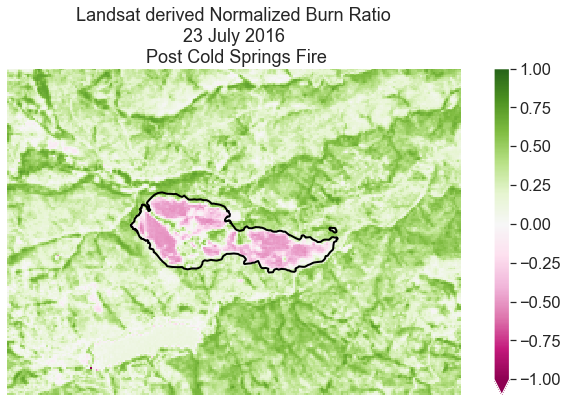

In [5]:
# Calculate NBR & plot
landsat_postfire_nbr = es.normalized_diff(
    landsat_post_fire[0], landsat_post_fire[2])

fig, ax = plt.subplots(figsize=(12, 6))

landsat_postfire_nbr.plot.imshow(cmap='PiYG',
                                 vmin=-1,
                                 vmax=1,
                                 ax=ax)
ax.set_axis_off()
ax.set(title="Landsat derived Normalized Burn Ratio\n 23 July 2016 \n Post Cold Springs Fire")


fire_bound_utmz13.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)
plt.show()

Next, calculate NBR for the pre-fire data. Note that you will have to download the data that is being used below from Earth Explorer following the lessons in this tutorial series. 

Also note that you will need to clip or crop the data so that you can subtract the post fire data from the pre fire data. The code to do this is hidden but you did this last week so you should know what to do!


In [6]:
# Get bounds to create crop extent
landsat_post_bounds = landsat_post_fire.rio.bounds()

# Create clip extent using the post fire data
landsat_clip = [mapping(box(*landsat_post_bounds))]

path_landsat_pre_st = os.path.join("cold-springs-fire",
                                   "outputs",
                                   "landsat_pre_st_hw.tif")

landsat_paths_pre = glob(os.path.join("cs-test-landsat",
                                      "*band[5-7]*.tif"))
landsat_paths_pre.sort()

landsat_pre_fire = combine_tifs(landsat_paths_pre)
landsat_pre_crop = landsat_pre_fire.rio.clip(landsat_clip)

In [7]:
# Are the before and after data the same shape?
landsat_pre_crop.shape == landsat_post_fire.shape

True

Next you can:

1. calculate NBR on the pre-fire data and then
2. calculate difference dNBR by subtracting the post fire data FROM the pre (pre-post)

The code for this is hidden below because you know how to do this! 

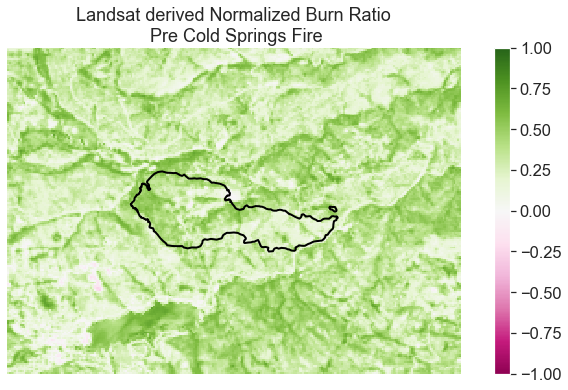

In [8]:
nbr_landsat_pre_fire = es.normalized_diff(
    landsat_pre_crop[0], landsat_pre_crop[2])

# Plot the data

fig, ax = plt.subplots(figsize=(12, 6))

nbr_landsat_pre_fire.plot.imshow(cmap='PiYG',
                                 vmin=-1,
                                 vmax=1,
                                 ax=ax)
ax.set_axis_off()
ax.set(title="Landsat derived Normalized Burn Ratio\n Pre Cold Springs Fire")


fire_bound_utmz13.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)
plt.show()

Finally, calculate the difference between the two rasters to calculate the Difference Normalized Burn Ratio (dNBR). Remember to subtract post fire from pre fire. 

In [9]:
# Calculate dnbr
dnbr_landsat = nbr_landsat_pre_fire - landsat_postfire_nbr
dnbr_landsat

<xarray.DataArray (y: 177, x: 246)>
array([[ 0.04334395,  0.08738004,  0.08557479, ..., -0.0464032 ,
        -0.04672406, -0.02588047],
       [-0.03804426,  0.0463331 ,  0.06357774, ..., -0.02489721,
        -0.01969055, -0.02097242],
       [-0.06424496, -0.00296728,  0.01671243, ..., -0.03296439,
        -0.01451225, -0.01793674],
       ...,
       [-0.0817215 , -0.01774661, -0.00354044, ..., -0.00419808,
         0.01162347,  0.018333  ],
       [ 0.01980466, -0.14882202, -0.06864975, ..., -0.02433778,
        -0.02668495, -0.02546721],
       [-0.1268123 ,  0.00381417, -0.05303623, ...,  0.02951792,
        -0.00804127, -0.03982081]])
Coordinates:
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
    spatial_ref  int64 0

Finally you can classify the data. Remember that dNBR has a set of classification bins and associated categories that are commonly used. When you have calculated NBR - classify the output raster using the `np.digitize()`
function. Use the dNBR classes below.

| SEVERITY LEVEL  | | dNBR RANGE |
|------------------------------|
| Enhanced Regrowth | |   > -.1 |
| Unburned       |  | -.1 to + .1 |
| Low Severity     | | +.1 to +.27 |
| Moderate Severity  | | +.27 to +.66 |
| High Severity     |  |  > +.66  |

NOTE: your min and max values for NBR may be slightly different from the table
shown above. In the code example above, `np.inf` is used to indicate any values larger than `.66`. 

The code to classify below is hidden! You learned how to classify rasters in week 2 of this course.


<i class="fa fa-star"></i> **Data Tip:** You learned how to classify rasters in the [lidar raster lessons]({{ site.url }}/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/)
{: .notice--success }

In [10]:
# Define dNBR classification bins
dnbr_class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]

#dnbr_landsat_class = np.digitize(dnbr_landsat, dnbr_class_bins)

dnbr_landsat_class = xr.apply_ufunc(np.digitize,
                                    dnbr_landsat,
                                    dnbr_class_bins)
dnbr_landsat_class

<xarray.DataArray (y: 177, x: 246)>
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 1, 2, ..., 2, 2, 2],
       [1, 2, 2, ..., 2, 2, 2]])
Coordinates:
  * y            (y) float64 4.428e+06 4.428e+06 ... 4.423e+06 4.423e+06
  * x            (x) float64 4.557e+05 4.557e+05 4.557e+05 ... 4.63e+05 4.63e+05
    spatial_ref  int64 0


Finally you are ready to plot your data. Note that legends in python can be tricky so you are provided with two legend options below. In the first plot, you create a legend with individual boxes. 
Creating a legend this way forces you to use matplotlib patches. Effectively you are drawing each box to create a legend from colors you've used in your image. 

In [11]:
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"]

nbr_colors = ["g",
              "yellowgreen",
              "peachpuff",
              "coral",
              "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

Once you setup the legend with 

1. a ListedColormap: this is a discrete colormap. Thus it will only contain `n` colors rather than a gradient of colors.
2. A list of titles for each category in your classification scheme: this is what will be "written" on your legend

You are ready to plot. Below you add a custom legend with unique boxes for each class. This is one way to create a legend. It requires a bit more knowledge of matplotlib under the hood to make this work! 

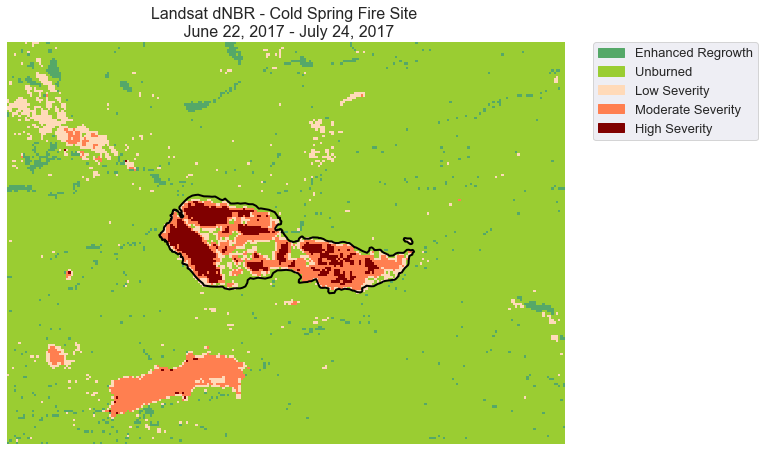

In [12]:
# Plot the data with a custom legend
fig, ax = plt.subplots(figsize=(10, 8))

im = dnbr_landsat_class.plot.imshow(ax=ax,
                                    cmap=nbr_cmap,
                                    add_colorbar=False)

fire_bound_utmz13.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)

unique_classes = np.unique(dnbr_landsat_class)
ep.draw_legend(im,
               classes=unique_classes,
               titles=dnbr_cat_names)
ax.set_axis_off()
ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
             fontsize=16)

plt.show()

In [13]:
# # Plot the data with a custom legend
# fig, ax = plt.subplots(figsize=(10, 8))

# im = dnbr_landsat_class.plot.imshow(cmap=nbr_cmap,
#                                     vmin=-1,
#                                     vmax=1,
#                                     ax=ax)
# # im = ax.imshow(dnbr_landsat_class,
# #                cmap=nbr_cmap,
# #                extent=landsat_extent)

# fire_bound_utmz13.plot(ax=ax,
#                        color='None',
#                        edgecolor='black',
#                        linewidth=2)

# values = np.unique(dnbr_landsat_class.ravel())

# ep.draw_legend(im,
#                classes=values,
#                titles=dnbr_cat_names)

# ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
#              fontsize=16)

# # turn off ticks
# ax.set_axis_off()
# plt.show()

### Create a Colorbar Legend - BONUS!

You can also create a discrete colorbar with labels. This method might be a bit less technical to follow. You can decide what type of legend you prefer for your homework. 

In [14]:
# Grab raster unique values (classes)
values = np.unique(dnbr_landsat_class).tolist()

# Add another index value because for n categories
# you need n+1 values to create bins
values = [0] + values

# Make a color map of fixed colors
nbr_colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

# But the goal is the identify the MIDDLE point
# of each bin to create a centered tick
bounds = [((a + b) / 2) for a, b in zip(values[:-1], values[1::1])] + [5.5]

# Define normalization
norm = colors.BoundaryNorm(bounds, nbr_cmap.N)

Then, plot the data but this time add a colorbar rather than a custom legend.

/Users/leahwasser/opt/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/xarray/plot/plot.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  primitive = ax.imshow(z, **defaults)


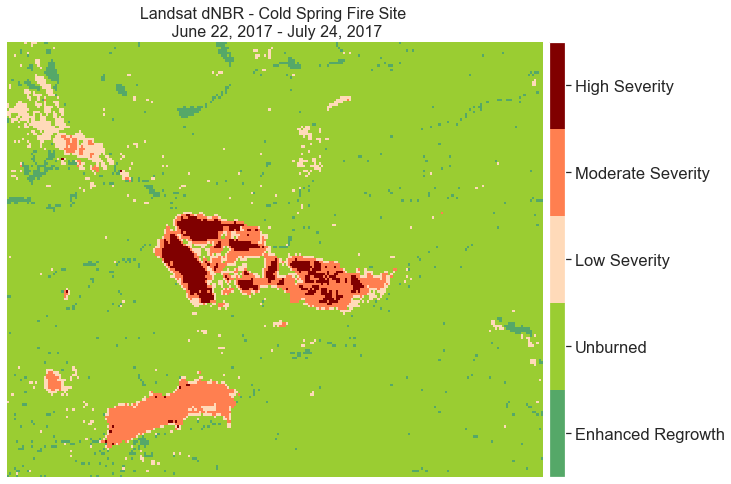

In [15]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

im = dnbr_landsat_class.plot.imshow(ax=ax,
                                    cmap=nbr_cmap,
                                    norm=norm,
                                    add_colorbar=False)

cbar = ep.colorbar(im)

cbar.set_ticks([np.unique(dnbr_landsat_class)])
cbar.set_ticklabels(dnbr_cat_names)
ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
             fontsize=16)

# Turn off ticks
ax.set_axis_off()
plt.show()

### Histogram of dNBR values
A histogram of the data is useful to better understand the distribution. 

In [16]:
# unique, counts = np.unique(dnbr_landsat_class.ravel(), return_counts=True)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.bar(unique, counts,
#        color="purple")

# ax.set_title("Histogram of Landsat dNBR values - \nthis is not a homework plot. \nyou can use it to check your results if you want",
#              fontsize=16)
# ax.set_xticks(unique)
# # get just the labels for unique values
# dnbr_lab = [dnbr_cat_names[i] for i in unique]
# ax.set_xticklabels(dnbr_lab)



## Calculate Total Area of Burned Area



Once you have classified your data, you can calculate the total burn area.

For this lesson, you are comparing the area calculated using modis that is "high severity" to that of Landsat.

You can calculate this using a loop, a function or manually - like so:

In [17]:
# To calculate area, multiply:
# number of pixels in each bin by image resolution
# Result will be in total square meters


# TODO - this code isn't running -- but also we may be giving them the entire answer in this
# lesson - so let's reassess!

# landsat_pixel = landsat_pre_crop.rio.resolution(
# )[0] * landsat_pre_crop.rio.resolution()[0]

# burned_landsat = (dnbr_landsat_class[dnbr_landsat_class == 5]).size
# burned_landsat = np.multiply(burned_landsat, landsat_pixel)

# print("Landsat Severe Burn Area:", burned_landsat)

## Export dNBR Raster to Geotiff
Finally you can export the newly created dNBR raster to a geotiff. You can use all of the same metadata as you've been using for the other landsat rasters. However, in this case we need to UPDATE the count or number of layers in the raster. We only have one layer in the dNBR raster vs 7 in our landsat stacks. 


In [18]:
# TODO - unhide this section - i suggest just exporting a single tif here as an example

#dnbr_meta = landsat_post_meta.copy()

In [19]:
# # update the metadata (i maybe want to make a copy of this ??)
# dnbr_meta['count'] = 1
# dnbr_meta

In [20]:
# # add write dNBR raster here....
# dnbr_path = "data/cold-springs-fire/outputs/dnbr_landsat.tif"
# with rio.open(dnbr_path, "w", **dnbr_meta) as src:
#     src.write(dnbr_landsat_class.astype(np.int16), 1)